In [ ]:
'''
Afshin Karimi
99210431
'''

In [1]:

import numpy as np
import torch 
import torch.nn as nn
import torch.optim as optim
import gym
import copy


In [2]:
env = gym.make("CartPole-v1")

In [3]:
n_actions = env.action_space.n
input_dim = env.observation_space.shape[0]
model =nn.Sequential(nn.Linear(input_dim,32),
                     nn.ReLU(),
                     nn.Linear(32,16),
                     nn.ReLU(),
                     nn.Linear(16,n_actions))
model_target = copy.deepcopy(model)

loss_fn = nn.MSELoss()
Learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(),lr= Learning_rate)

                

In [4]:
def learning(replay_memory,traget_update,minibatch_size = 32):
    
    minibatch = np.random.choice(replay_memory, minibatch_size ,replace = True)
    s = np.array(list(map(lambda x:x['s'] , minibatch)))
    a = np.array(list(map(lambda x:x['a'] , minibatch)))
    r = np.array(list(map(lambda x:x['r'] , minibatch)))
    sprime = np.array(list(map(lambda x:x['sprime'] , minibatch)))
    done = np.array(list(map(lambda x:x['done'] , minibatch)))
    global model_target
    if traget_update: model_target = copy.deepcopy(model)    
    q_s = model(torch.tensor(s).float())
    q_sprime = model_target(torch.tensor(sprime).float())
    q_s_target = q_s.detach().clone()
    
    
    for i,(s1,a1,r1,q_sprime1,done1) in enumerate(zip(s,a,r,q_sprime,done)):
        if not done1: target = r1 + gamma * torch.max(q_sprime1)
        else:target = r1
        q_s_target[i][a1] = target
            
    optimizer.zero_grad()
    loss = loss_fn(q_s , q_s_target)
    loss.backward()
    optimizer.step()
            

In [5]:
n_episodes = 1000
gamma = 0.98
epsilon = 0.05
minibatch_size = 32
r_sums = []
replay_memory = []
mem_max_size = 120000
for n in range(n_episodes):
    s = env.reset()
    done = False
    r_sum = 0
    flag = 1
    
    while not done:
        q_s = model(torch.tensor(s).float())
        
        if np.random.random() < epsilon :
            a = env.action_space.sample()
        else:
            a = np.argmax(q_s.detach().numpy())
            
        sprime,r,done,info = env.step(a)
        r_sum += r
        if len(replay_memory) > mem_max_size:
            replay_memory.pop(0)
        replay_memory.append({"s":s,"a":a,"r":r,"sprime":sprime,"done":done})
        s = sprime
        traget_update = False
        if n %1 == 0 and flag == 1:
            flag = 0 
            traget_update = True  
        learning(replay_memory,traget_update,minibatch_size = minibatch_size)
    if epsilon > 0.1:
        epsilon -= 0.001
    r_sums.append(r_sum)
    if n % 100 == 0:
        print("Episode %d: %f" %(n+1 , r_sum))
        

Episode 1: 11.000000
Episode 101: 203.000000
Episode 201: 228.000000
Episode 301: 259.000000
Episode 401: 241.000000
Episode 501: 278.000000
Episode 601: 411.000000
Episode 701: 500.000000
Episode 801: 252.000000
Episode 901: 500.000000


Text(0, 0.5, 'Reward')

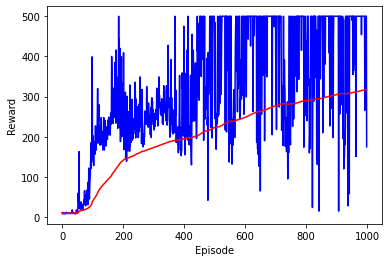

In [6]:

%matplotlib inline 
import matplotlib.pyplot as plt
MA = [] # moving average to show uptrend in rewards
temp = 0
j = 1
for i in r_sums:
    temp += i
    MA.append(temp/j)
    j+=1
plt.plot(r_sums,color="b")
plt.plot(MA,color="r")
plt.xlabel("Episode")
plt.ylabel("Reward")